# CNN from scratch - Keras+TensorFlow

This is for CNN models built from scratch, using Keras based on TensorFlow.
First, some preparation work.

In [1]:
from keras.layers import Conv2D, MaxPooling2D, Input, Dense, Flatten, Activation, add
from keras.layers.core import Dropout
from keras.layers.normalization import BatchNormalization
from keras.layers.pooling import GlobalAveragePooling2D
from keras.optimizers import RMSprop
from keras.models import Model, Sequential, load_model
from keras.callbacks import ModelCheckpoint, EarlyStopping
from keras import backend as ktf
from keras.preprocessing.image import ImageDataGenerator
import matplotlib.pyplot as plt
import numpy as np
import csv
%matplotlib notebook

Using TensorFlow backend.


Read the Dog Breed data. They had been resized to (32,32,3) and saved in .npy.

In [13]:
# by default, there would be 10357 training data and 10222 test data(for submission)
with open('../data/all.npy', 'rb') as file:
    data = np.load(file)[()]
    
# check if the size is right
print(len(data['X_train']), len(data['X_test']), data['X_train'][0].shape)

10222 10357 (32, 32, 3)


In [14]:
# transfrom to numpy array
data['X_train'] = np.array(data['X_train'])
data['X_test'] = np.array(data['X_test'])

# code the labels (0-119)
label = []
with open('../data/sample_submission.csv', 'rt') as file:
    fileToRead = csv.reader(file)
    label = next(fileToRead)
label.pop(0)
label = {breed:idx for idx, breed in enumerate(label)}
data['y_train'] = np.array([label[breed] for breed in data['y_train']])

# see if we get the data correctly
print('train size: ', data['X_train'].shape)
print('label size: ', data['y_train'].shape)
print('test size: ', data['X_test'].shape)
print('label examples: ', data['y_train'][:10])

train size:  (10222, 32, 32, 3)
label size:  (10222,)
test size:  (10357, 32, 32, 3)
label examples:  [19 37 85 15 49 10 10 18  7 97]


## Simple CNN model

Build a simple CNN model using Keras and then train from scratch.

In [25]:
# model architecture
# [batchnorm-Conv-Conv-maxpool]x2 - [dense]x2 - [softmax]
simple_CNN = Sequential()
simple_CNN.add(BatchNormalization(input_shape=(32, 32, 3)))
simple_CNN.add(Conv2D(32, (3, 3), activation='relu', padding='same'))
simple_CNN.add(Conv2D(32, (3, 3), activation='relu', padding='same'))
simple_CNN.add(MaxPooling2D((2, 2))) # (16,16,32)
simple_CNN.add(Dropout(0.2))

simple_CNN.add(BatchNormalization())
simple_CNN.add(Conv2D(64, (3, 3), activation='relu', padding='same'))
simple_CNN.add(Conv2D(64, (3, 3), activation='relu', padding='same'))
simple_CNN.add(MaxPooling2D((2, 2))) # (8,8,64)
simple_CNN.add(Dropout(0.2))

simple_CNN.add(BatchNormalization())
simple_CNN.add(Conv2D(128, (3, 3), activation='relu', padding='same'))
simple_CNN.add(Conv2D(128, (3, 3), activation='relu', padding='same'))
simple_CNN.add(MaxPooling2D((2, 2))) # (4,4,128)
simple_CNN.add(Dropout(0.2))

simple_CNN.add(Flatten())
simple_CNN.add(Dense(1024, activation='relu'))
simple_CNN.add(Dropout(0.45))
simple_CNN.add(Dense(120, activation='softmax'))

rmsprop = RMSprop(lr=0.01, decay=0.99)
simple_CNN.compile(loss='sparse_categorical_crossentropy', optimizer=rmsprop, metrics=['accuracy'])

# train the model
checkpoint = ModelCheckpoint('../models/simpleCNN_{epoch:02d}-{loss:.4f}.h5',
                             monitor='loss',
                             save_best_only=True)
earlystop = EarlyStopping(min_delta=0.0001, patience=3)

# use test data to monitor early stopping
simple_CNN.fit(data['X_train'], data['y_train'].reshape(-1,1),
               batch_size=64,
               epochs=200,
               callbacks=[],
               initial_epoch=0)

Epoch 1/200
  960/10222 [=>............................] - ETA: 77s - loss: 15.1872 - acc: 0.0115

KeyboardInterrupt: 

In [3]:
# resume training
model = load_model('../models/simpleCNN_86-0.0034.h5')

# set the loss and optimizer
rmsprop = RMSprop(lr=0.0000000044)
model.compile(optimizer=rmsprop, loss='sparse_categorical_crossentropy', metrics=['accuracy'])

# train the model
checkpoint = ModelCheckpoint('../models/simpleCNN_{epoch:02d}-{loss:.4f}.h5',
                             monitor='loss',
                             save_best_only=True)
earlystop = EarlyStopping(min_delta=0.0001, patience=5)

model.fit(data['X_train'], data['y_train'].reshape(-1,1),
               batch_size=64,
               epochs=200,
               validation_data=(data['X_test'], data['y_test'].reshape(-1, 1)),
               callbacks=[checkpoint, earlystop],
               initial_epoch=87)

Train on 41000 samples, validate on 1000 samples
Epoch 88/200
41000/41000 [==============================] - 88s - loss: 0.0125 - acc: 0.9979 - val_loss: 0.0090 - val_acc: 0.9980
Epoch 89/200
41000/41000 [==============================] - 89s - loss: 0.0143 - acc: 0.9975 - val_loss: 0.0090 - val_acc: 0.9980
Epoch 90/200
41000/41000 [==============================] - 93s - loss: 0.0135 - acc: 0.9973 - val_loss: 0.0090 - val_acc: 0.9980
Epoch 91/200
39104/41000 [===========================>..] - ETA: 4s - loss: 0.0130 - acc: 0.9976

KeyboardInterrupt: 

## Inspect the wrong answers

It's often helpful to see how the model classifies the wrong results. Here we randomly pick 10 wrong classified images from test set.

In [3]:
model = load_model('../models/simpleResCNN.h5')
pred = np.argmax(model.predict(data['X_test']), axis=1)
wrong_idx = [i for i in range(len(pred)) if pred[i] != data['y_test'][i]]

<IPython.core.display.Javascript object>


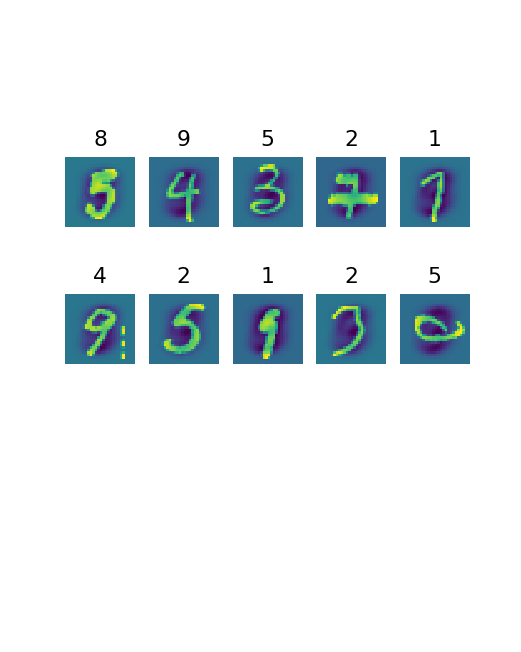

In [12]:
np.random.shuffle(wrong_idx)
fig = plt.figure(figsize=(4, 5))
for i in range(1,6):
    for j in range(1,3):
        idx = wrong_idx.pop()
        a = fig.add_subplot(j,5,i)
        plt.imshow(data['X_test'][idx].reshape((28,28)))
        plt.axis('off')
        plt.title(pred[idx])
        
plt.show()

## Hyperparameter finetuning

We finetune the hyperparameters and also structures of SimpleCNN.
Here we use **random search** for following hyperparameters:
- initial learning rate
- dropout rate(for fully-connected layer)
- dense layer unit size
And **manual search** for following structures:
- convolution depth for each modules
- number of modules

In [35]:
# validate the model and return the test error
def simpleCNN_model(lr=0.001, dropout=0.5, dense_dim=1024, drop_conv=True, avgpool=True):
    simple_CNN = Sequential()
    simple_CNN.add(BatchNormalization(input_shape=(32, 32, 3)))
    simple_CNN.add(Conv2D(32, (3, 3), activation='relu', padding='same'))
    simple_CNN.add(Conv2D(32, (3, 3), activation='relu', padding='same'))
    simple_CNN.add(MaxPooling2D((2, 2))) # (14,14,32)
    if drop_conv:
        simple_CNN.add(Dropout(0.2))

    simple_CNN.add(BatchNormalization())
    simple_CNN.add(Conv2D(64, (3, 3), activation='relu', padding='same'))
    simple_CNN.add(Conv2D(64, (3, 3), activation='relu', padding='same'))
    simple_CNN.add(MaxPooling2D((2, 2))) # (7,7,64)
    if drop_conv:
        simple_CNN.add(Dropout(0.2))

    if avgpool:
        simple_CNN.add(GlobalAveragePooling2D())
    else:
        simple_CNN.add(Flatten())
        simple_CNN.add(Dense(dense_dim, activation='relu'))
        simple_CNN.add(Dropout(dropout))
    simple_CNN.add(Dense(120, activation='softmax'))

    # set loss and optimizer
    rmsprop = RMSprop(lr=lr, decay=0.999)
    simple_CNN.compile(loss='sparse_categorical_crossentropy', optimizer=rmsprop, metrics=['accuracy'])

    # use test data to monitor early stopping
    history = simple_CNN.fit(data['X_train'][:1000], data['y_train'][:1000].reshape(-1,1),
                   batch_size=64,
                   epochs=1,
                   initial_epoch=0,
                   verbose=False)
    return history.history['loss'][0], history.history['acc'][0]

First, random search. Each run is only 1 epoch with 1000 validation data.
Hyperparamters are sampled from uniform distribution with different range, while hidden unit size requires integer.
Structure 'switches' are sampled from binomial distribution(p=0.5).

In [36]:
# validation: 1000; 1 epoch
# finetune list: initial learning rate, dropout rate, hidden unit size
best_parameters={'lr': 0.001, 'dropout': 0.5, 'dense_dim': 1024}
lowest_err = 1000
lr_range = (0.1,0.0001); dropout_range = (0.3,0.8); dense_range = (512,2048)
while True:
    lr = np.random.uniform(lr_range[0], lr_range[1])
    dropout = np.random.uniform(dropout_range[0], dropout_range[1])
    dense_dim = int(np.random.uniform(dense_range[0], dense_range[1]))
    drop_conv, avgpool = np.random.binomial(1,0.5,2)
    ktf.clear_session()
    test_err, test_acc = simpleCNN_model(lr, dropout, dense_dim, drop_conv, avgpool)
    if test_err < lowest_err:
        print('new lowest: ', round(test_err,2), round(test_acc,2), 
              (round(lr,4), round(dropout,2), dense_dim, bool(drop_conv), bool(avgpool)))
        lowest_err = test_err
        best_parameters['lr'] = lr
        best_parameters['dropout'] = dropout
        best_parameters['dense_dim'] = dense_dim

new lowest:  11.62 0.01 (0.0078, 0.77, 1223, True, False)
new lowest:  7.41 0.0 (0.0326, 0.4, 1623, True, True)
new lowest:  4.84 0.01 (0.0019, 0.58, 1075, False, True)


KeyboardInterrupt: 

## SimpleCNN with data augmentation

Here, we try to reduce the error in a different way, from a perspective of data. In theory, the classifier can learn better with more data. Data augmentation is a way to increase the training set size. It realizes this by slightly transforming the original data, and using original and also this extra transformed dataset to train the model.

In [11]:
# set the data generator to transform the data
idg = ImageDataGenerator(width_shift_range=0.05,
                         fill_mode='constant')
# build the model
simple_CNN = Sequential()
simple_CNN.add(BatchNormalization(input_shape=(28, 28, 1)))
simple_CNN.add(Conv2D(32, (3, 3), activation='relu', padding='same'))
simple_CNN.add(Conv2D(32, (3, 3), activation='relu', padding='same'))
simple_CNN.add(MaxPooling2D((2, 2))) # (14,14,32)
simple_CNN.add(Dropout(0.2))

simple_CNN.add(BatchNormalization())
simple_CNN.add(Conv2D(64, (3, 3), activation='relu', padding='same'))
simple_CNN.add(Conv2D(32, (3, 3), activation='relu', padding='same'))
simple_CNN.add(MaxPooling2D((2, 2))) # (7,7,64)
simple_CNN.add(Dropout(0.2))

simple_CNN.add(Flatten())
simple_CNN.add(Dense(1392, activation='relu'))
simple_CNN.add(Dropout(0.45))
simple_CNN.add(Dense(10, activation='softmax'))

# set loss and optimizer
rmsprop = RMSprop(lr=0.0044, decay=0.99)
simple_CNN.compile(loss='sparse_categorical_crossentropy',
                   optimizer=rmsprop,
                   metrics=['accuracy'])

# train the model using indefinite number of training data
checkpoint = ModelCheckpoint('../models/simpleCNN_aug_{epoch:02d}-{loss:.4f}.h5',
                             monitor='loss',
                             save_best_only=True)
earlystop = EarlyStopping(min_delta=0.0001, patience=3)

simple_CNN.fit_generator(idg.flow(data['X_train'], 
                                      data['y_train'].reshape(-1, 1), 
                                      batch_size=64),
                         steps_per_epoch=len(data['X_train'])/64,
                         initial_epoch=0,
                         epochs=100,
                         callbacks=[checkpoint, earlystop],
                         validation_data=(data['X_test'], data['y_test'].reshape(-1, 1)))

Epoch 1/100
641/640 [==============================] - 97s - loss: 0.7405 - acc: 0.7713 - val_loss: 0.3624 - val_acc: 0.9090
Epoch 2/100
 77/640 [==>...........................] - ETA: 84s - loss: 0.5269 - acc: 0.8375

KeyboardInterrupt: 

In [6]:
# resume training
model = load_model('../models/simpleCNN_aug_44-0.9536.h5')

# set the loss and optimizer
rmsprop = RMSprop(lr=0.00044,decay=0.99)
model.compile(optimizer=rmsprop, loss='sparse_categorical_crossentropy', metrics=['accuracy'])

# train the model
checkpoint = ModelCheckpoint('../models/simpleCNN_aug_{epoch:02d}-{loss:.4f}.h5',
                             monitor='loss',
                             save_best_only=True)
earlystop = EarlyStopping(min_delta=0.0001, patience=5)

model.fit_generator(idg.flow(data['X_train'], 
                                  data['y_train'].reshape(-1, 1), 
                                  batch_size=64),
                         steps_per_epoch=len(data['X_train'])/64,
                         initial_epoch=45,
                         epochs=100,
                         callbacks=[checkpoint, earlystop],
                         validation_data=(data['X_test'], data['y_test'].reshape(-1, 1)))

Epoch 46/100
641/640 [==============================] - 87s - loss: 0.8927 - acc: 0.7113 - val_loss: 0.3978 - val_acc: 0.8970
Epoch 47/100
641/640 [==============================] - 87s - loss: 0.8764 - acc: 0.7191 - val_loss: 0.3935 - val_acc: 0.8970
Epoch 48/100
641/640 [==============================] - 86s - loss: 0.8735 - acc: 0.7180 - val_loss: 0.3911 - val_acc: 0.8980
Epoch 49/100
641/640 [==============================] - 87s - loss: 0.8671 - acc: 0.7242 - val_loss: 0.3896 - val_acc: 0.8990
Epoch 50/100
641/640 [==============================] - 87s - loss: 0.8573 - acc: 0.7242 - val_loss: 0.3891 - val_acc: 0.8990
Epoch 51/100
641/640 [==============================] - 88s - loss: 0.8628 - acc: 0.7236 - val_loss: 0.3875 - val_acc: 0.8990
Epoch 52/100
641/640 [==============================] - 86s - loss: 0.8583 - acc: 0.7245 - val_loss: 0.3864 - val_acc: 0.8990
Epoch 53/100
641/640 [==============================] - 86s - loss: 0.8540 - acc: 0.7262 - val_loss: 0.3850 - val_acc:

KeyboardInterrupt: 

## Create submissions

Load the saved trained models and produce predictions for submission on Kaggle.

In [4]:
from lib.data_utils import create_submission
from keras.models import load_model

# for simple CNN model
model = load_model('../models/simpleCNN_86-0.0034.h5')
print('Load model successfully.')
create_submission(model, '../data/test.csv', '../submission/submission_simpleCNN_tuned_87.csv', 128)

Load model successfully.
28000/28000 [==============================] - 13s    


In [8]:
history = simpleCNN_model()

Train on 4000 samples, validate on 1000 samples
Epoch 1/1
4000/4000 [==============================] - 18s - loss: 2.2335 - acc: 0.2383 - val_loss: 2.2805 - val_acc: 0.1230


In [10]:
print(history.history)

{'loss': [2.233535957336426], 'acc': [0.23824999999999999], 'val_loss': [2.2805455265045165], 'val_acc': [0.12300000023841857]}
